#### Black-Scholes Model
This file implements a workflow to analyze and compare the pricing of options for a given stock using the Black-Scholes model. <br>We first cover the implementation that ignores dividends and subsequently explore the effect of dividends on estimations.

In [ ]:
import pandas as pd
import warnings
import sys
import matplotlib.pyplot as plt

from datetime import datetime
from blackScholesModel import BlackScholesModel

sys.path.insert(0, '..')

from utils import *

warnings.filterwarnings("ignore")

In [2]:
ticker = 'AAPL'
stock_data = fetch_stock_data(ticker)
expiry, calls, puts = fetch_options_data(ticker)
expiry = pd.to_datetime(expiry)
days_to_expiry = abs((expiry - datetime.now()).days)

[*********************100%***********************]  1 of 1 completed


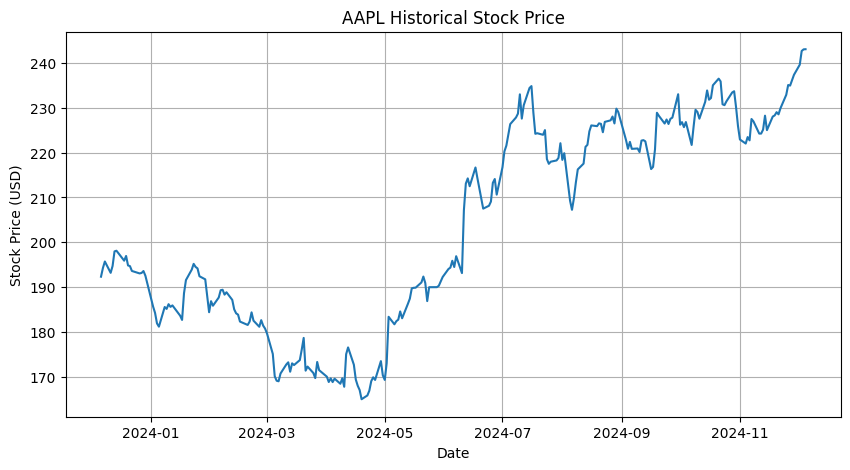

In [3]:
plt.figure(figsize=(10, 5))
plt.plot(stock_data['Close'])
plt.title(f'{ticker} Historical Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.grid(True)

**Note:** Black-Scholes assumes that the volatility of the underlying asset is constant 

In [4]:
# Get historical volatility
historical_volatility = calculate_historical_volatility(stock_data)

**Note:** A known issue with Black-Scholes is that it underestimates the tail density, leading to gross underestimations of options with strike prices that are not *in-the-money*.<br>For this reason, we exclude *out-of-the-money* strikes from our error calculation.

In [5]:
# Calculate the Black-Scholes model
underlying_price = float(stock_data['Close'].iloc[-1])
# strike_price is variable from options_data
years_to_expiry = float(days_to_expiry / 365)
risk_free_rate = float(fetch_risk_free_rate()) / 100

# Create a pandas DataFrame to store the results
call_results = pd.DataFrame(columns=['Strike', 'Calculated Price', 'Last Price', 'Error'])
put_results = pd.DataFrame(columns=['Strike', 'Calculated Price', 'Last Price', 'Error'])

for strike, last_price in zip(calls['strike'], calls['lastPrice']):
    call = BlackScholesModel(S=underlying_price, K=strike, T=years_to_expiry, r=risk_free_rate, sigma=historical_volatility, q=0)
    data = pd.Series({
        "Strike": strike,
        "Calculated Price": call.call_option_price(),
        "Last Price": last_price,
        "Error": abs(call.call_option_price() - last_price) / last_price
    })
    call_results = pd.concat([call_results, data.to_frame().T], ignore_index=True)

# Calculate the average error
average_call_error = call_results[call_results['Error'] != 1]['Error'].mean()
print(f"Average Call Error: {((average_call_error)):.2f}%")

for strike, last_price in zip(puts['strike'], puts['lastPrice']):
    put = BlackScholesModel(S=underlying_price, K=strike, T=years_to_expiry, r=risk_free_rate, sigma=historical_volatility, q=0)
    data = pd.Series({
        "Strike": strike,
        "Calculated Price": put.put_option_price(),
        "Last Price": last_price,
        "Error": abs(put.put_option_price() - last_price) / last_price
    })
    put_results = pd.concat([put_results, data.to_frame().T], ignore_index=True)

# Calculate the average error
average_put_error = put_results[put_results['Error'] != 1]['Error'].mean()
print(f"Average Put Error: {((average_put_error)):.2f}%")

[*********************100%***********************]  1 of 1 completed

Average Call Error: 0.27%
Average Put Error: 0.77%


**Note:** As we move on to calculate a model that incorporates dividends, the model only considers a continuously compounded dividend. This makes the actual dividend date irrelevant and hence results in large errors for stocks with larger dividend yield. 

In [6]:
dividend_yield = fetch_dividend_yield(ticker)

# Create a pandas DataFrame to store the results
call_results_div = pd.DataFrame(columns=['Strike', 'Calculated Price', 'Last Price', 'Error'])
put_results_div = pd.DataFrame(columns=['Strike', 'Calculated Price', 'Last Price', 'Error'])

for strike, last_price in zip(calls['strike'], calls['lastPrice']):
    call_div = BlackScholesModel(S=underlying_price, K=strike, T=years_to_expiry, r=risk_free_rate, sigma=historical_volatility, q=dividend_yield)
    data = pd.Series({
        "Strike": strike,
        "Calculated Price": call_div.call_option_price(),
        "Last Price": last_price,
        "Error": abs(call_div.call_option_price() - last_price) / last_price
    })
    call_results_div = pd.concat([call_results_div, data.to_frame().T], ignore_index=True)

# Calculate the average error
average_div_call_error = call_results_div[call_results_div['Error'] != 1]['Error'].mean()
print(f"Average Call Error: {((average_div_call_error)):.2f}%")

for strike, last_price in zip(puts['strike'], puts['lastPrice']):
    put_div = BlackScholesModel(S=underlying_price, K=strike, T=years_to_expiry, r=risk_free_rate, sigma=historical_volatility, q=dividend_yield)
    data = pd.Series({
        "Strike": strike,
        "Calculated Price": put_div.put_option_price(),
        "Last Price": last_price,
        "Error": abs(put_div.put_option_price() - last_price) / last_price
    })
    put_results_div = pd.concat([put_results_div, data.to_frame().T], ignore_index=True)

# Calculate the average error
average_div_put_error = put_results_div[put_results_div['Error'] != 1]['Error'].mean()
print(f"Average Put Error: {((average_div_put_error)):.2f}%")



Average Call Error: 0.26%
Average Put Error: 0.77%


If you cant see any difference in the call or put errors, try a longer time to expiry ( *dividend effect may be reduced as the discounting factor approaches 1* ). Also note that the impact of q on the relative price difference diminishes for deep in-the-money or out-of-the-money options.